# MITRE ATT&CK Group Technique Analysis

#Commands used to pull data 

import mitreattack.attackToExcel.attackToExcel as attackToExcel 
import mitreattack.attackToExcel.stixToDf as stixToDf

attackToExcel.export("enterprise-attack", "v9.0", "C://Users//cindy//Desktop//MITRE_Data_project")


In [1]:
#Import Packages and Set-Up
import pandas as pd
import matplotlib as mpl 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from wordcloud import WordCloud, STOPWORDS
from pandas.plotting import parallel_coordinates
import datetime as dt
import random



%matplotlib inline

import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True) 

In [2]:
#Define functions for later use

def convert_timestamp(my_col):
    my_col = pd.to_datetime(my_col)
    return my_col

def replace_commas(df):
    for i in df.columns:
        try:
            df[i].astype('str')
            df[i] = df[i].apply(lambda x: x.strip())
            df[i] = df[i].apply(lambda x: x.replace(",", ""))
        except:
            pass
    return df

def replace_bools(df):
    my_cols = df.columns
    for i in my_cols:
        if type(i) == 'bool':
            df[i] = df[i].astype('int')
    return df
  
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    '''Makes wordcloud grayscale colors'''
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

def random_redcolor_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    '''Creates a text wordcloud in various red hues.'''
    
    h = int(360.0 * 3.0 / 255.0)
    s = int(100.0 * float(random_state.randint(120, 255))  / 255.0)
    l = int(100.0 * float(random_state.randint(85, 220)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)
 

def calculate_last_active(last_seen):
    date = pd.to_datetime(dt.date.today())
    last_seen= date - last_seen
    last_seen = last_seen.astype('str')
    last_seen = last_seen.apply(lambda x : x.replace(' days', ''))
    last_seen = last_seen.astype('int') 
    return last_seen



In [3]:
#Set today's Date to use later
date = pd.to_datetime(dt.date.today())

#Set path where files are located
path = 'C:\\Users\\cindy\\Desktop\\MITRE_Data_project\\'

# Retreive raw data files from downloads

In [4]:
groups_df = pd.read_excel(path + 'enterprise-attack-v9.0.xlsx',sheet_name='groups', header=0, index_col=None)
groups_df.rename(columns={"associated groups":"Associated_Groups", "ID" : "Group_ID", "name": "Group_Name"}, inplace=True)
groups_df['created'] = convert_timestamp(groups_df['created'])
groups_df.drop(['url', 'last modified','version', 'associated groups citations', 'contributors'], axis=1, inplace=True)
groups_df.dtypes

Group_ID                     object
Group_Name                   object
description                  object
created              datetime64[ns]
Associated_Groups            object
dtype: object

In [5]:
groups_df['Associated_Groups'] = groups_df['Associated_Groups'].astype('str')
groups_df['Associated_Groups'] = groups_df['Associated_Groups'].apply(lambda x: x.replace(', ', ' | '))
groups_df.head()

,Group_ID,Group_Name,description,created,Associated_Groups
0,G0099,APT-C-36,[APT-C-36](https://attack.mitre.org/groups/G00...,2020-05-05,Blind Eagle
1,G0006,APT1,[APT1](https://attack.mitre.org/groups/G0006) ...,2017-05-31,Comment Crew | Comment Group | Comment Panda
2,G0005,APT12,[APT12](https://attack.mitre.org/groups/G0005)...,2017-05-31,DNSCALC | DynCalc | IXESHE | Numbered Panda
3,G0023,APT16,[APT16](https://attack.mitre.org/groups/G0023)...,2017-05-31,nan
4,G0025,APT17,[APT17](https://attack.mitre.org/groups/G0025)...,2017-05-31,Deputy Dog


In [6]:
groups_df.head()

,Group_ID,Group_Name,description,created,Associated_Groups
0,G0099,APT-C-36,[APT-C-36](https://attack.mitre.org/groups/G00...,2020-05-05,Blind Eagle
1,G0006,APT1,[APT1](https://attack.mitre.org/groups/G0006) ...,2017-05-31,Comment Crew | Comment Group | Comment Panda
2,G0005,APT12,[APT12](https://attack.mitre.org/groups/G0005)...,2017-05-31,DNSCALC | DynCalc | IXESHE | Numbered Panda
3,G0023,APT16,[APT16](https://attack.mitre.org/groups/G0023)...,2017-05-31,nan
4,G0025,APT17,[APT17](https://attack.mitre.org/groups/G0025)...,2017-05-31,Deputy Dog


# Add external data about the actors from Thai CERT source: https://apt.thaicert.or.th/cgi-bin/listgroups.cgi

In [7]:
#Data was compiled using APT Group information, but can also be pulled in JSON from https://apt.thaicert.or.th/cgi-bin/getcard.cgi?g=all&o=j
actors = pd.read_excel(path + 'MITRE_Actor_DATA2.xlsx',sheet_name='ACTOR_DETAIL', header=0, index_col=None)
actors

,Group_ID,Actor_Label,Country,Campaign Start,Last Seen,Affiliation,State-Sponsored,Organization
0,G0018,admin@338,China,2014-01-01,2015-12-31,Government,Probable,Unknown
1,G0130,Ajax,Iran,2010-01-01,2017-12-31,Government,Yes,Unknown
2,G0006,APT1,China,2006-01-01,2018-10-31,Military,Yes,2nd Bureau of the People’s Liberation Army (PL...
3,G0045,APT10,China,2009-01-01,2021-02-28,Intelligence,Yes,Tianjin bureau of the Chinese Ministry of Stat...
4,G0005,APT12,China,2009-01-01,2016-11-30,Government,Yes,Unknown
...,...,...,...,...,...,...,...,...
132,G0112,Windshift,Unattributed,2018-01-01,2018-12-31,Unknown,Unknown,Unknown
133,G0044,WinntiGroup,China,2010-01-01,2021-03-31,Government,Yes,Unknown
134,G0090,WIRTE,Middle East,2018-01-01,2019-04-30,Unknown,Unknown,Unknown
135,G0102,WIZARDSPIDER,Russia,2014-01-01,2021-05-20,CYBERCRIME,No,Unknown


# Merge the Actor Data from Thai CERT with the MITRE Data 

In [8]:
groups_df = groups_df.merge(actors, on= 'Group_ID', how='left')
groups_df

,Group_ID,Group_Name,description,created,Associated_Groups,Actor_Label,Country,Campaign Start,Last Seen,Affiliation,State-Sponsored,Organization
0,G0099,APT-C-36,[APT-C-36](https://attack.mitre.org/groups/G00...,2020-05-05,Blind Eagle,APT-C-36,South America,2018-01-01,2019-02-28,Unknown,Unknown,Unknown
1,G0006,APT1,[APT1](https://attack.mitre.org/groups/G0006) ...,2017-05-31,Comment Crew | Comment Group | Comment Panda,APT1,China,2006-01-01,2018-10-31,Military,Yes,2nd Bureau of the People’s Liberation Army (PL...
2,G0005,APT12,[APT12](https://attack.mitre.org/groups/G0005)...,2017-05-31,DNSCALC | DynCalc | IXESHE | Numbered Panda,APT12,China,2009-01-01,2016-11-30,Government,Yes,Unknown
3,G0023,APT16,[APT16](https://attack.mitre.org/groups/G0023)...,2017-05-31,nan,APT16,China,2015-01-01,2015-12-31,Unknown,Unknown,Unknown
4,G0025,APT17,[APT17](https://attack.mitre.org/groups/G0025)...,2017-05-31,Deputy Dog,APT17,China,2009-01-01,2017-09-30,Intelligence,Yes,Jinan bureau of the Chinese Ministry of State ...
...,...,...,...,...,...,...,...,...,...,...,...,...
116,G0044,Winnti Group,[Winnti Group](https://attack.mitre.org/groups...,2017-05-31,Blackfly,WinntiGroup,China,2010-01-01,2021-03-31,Government,Yes,Unknown
117,G0102,Wizard Spider,[Wizard Spider](https://attack.mitre.org/group...,2020-05-12,Grim Spider | TEMP.MixMaster | UNC1878,WIZARDSPIDER,Russia,2014-01-01,2021-05-20,CYBERCRIME,No,Unknown
118,G0128,ZIRCONIUM,[ZIRCONIUM](https://attack.mitre.org/groups/G0...,2021-03-24,APT31,APT31,China,2016-01-01,2021-02-28,Government,Yes,Unknown
119,G0018,admin@338,[admin@338](https://attack.mitre.org/groups/G0...,2017-05-31,nan,admin@338,China,2014-01-01,2015-12-31,Government,Probable,Unknown


# Add features for date and timestamp

In [9]:
groups_df['Campaign Start'] = groups_df['Campaign Start'].fillna(pd.to_datetime(dt.date.today()))
groups_df['Last Seen'] = groups_df['Last Seen'].fillna(pd.to_datetime(dt.date.today()))

count     121.000000
mean     2275.669421
std      1572.201193
min        58.000000
25%       945.000000
50%      2249.000000
75%      3287.000000
max      9190.000000
Name: Campaign_Duration, dtype: float64


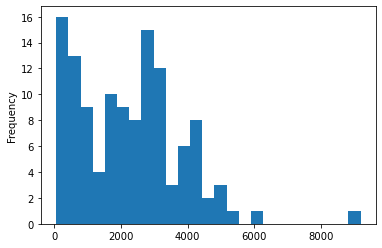

In [10]:
#Calculate how long the groups have been active
groups_df['Campaign_Duration'] =  (groups_df['Last Seen'] - groups_df['Campaign Start'] ).dt.days
print(groups_df['Campaign_Duration'].describe())
groups_df['Campaign_Duration'].plot(kind = 'hist', bins = 25);

<ipython-input-11-b1da43eb5978>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-b1da43eb5978>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



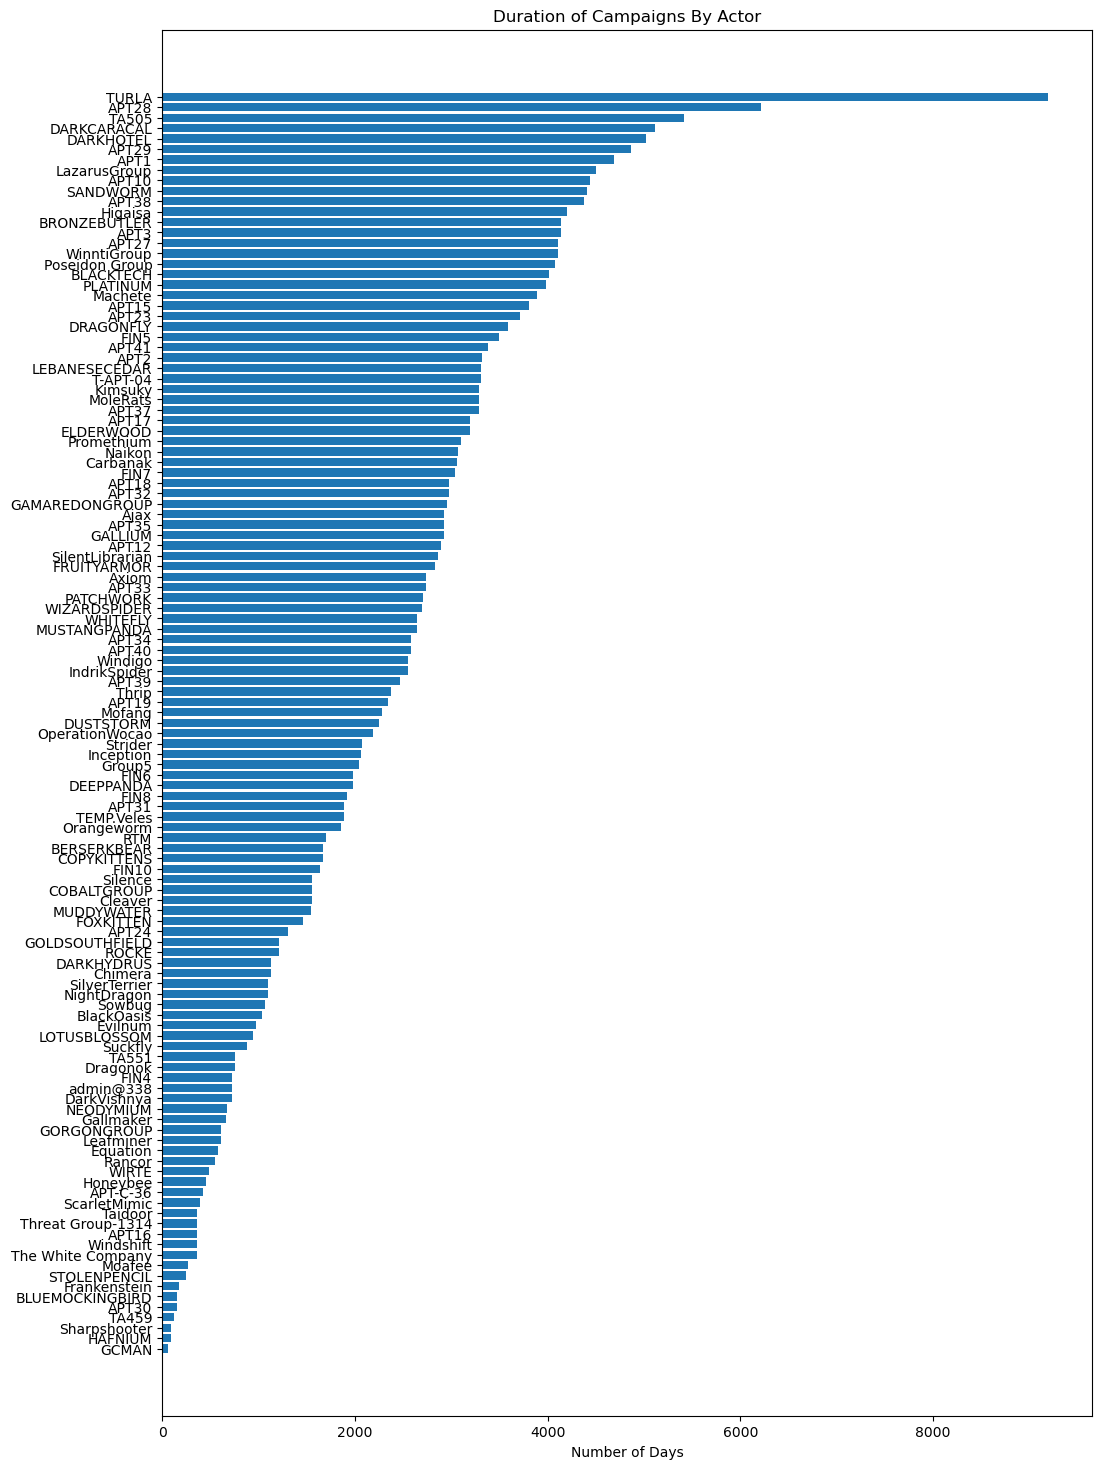

In [11]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12,18))

#Plot campaign duration by country
dur_country = groups_df[['Campaign_Duration', 'Country', 'Actor_Label']]
dur_country.drop_duplicates(inplace=True)
dur_country.sort_values(by = 'Campaign_Duration', inplace=True, ascending=False)
y_pos = np.arange(len(dur_country['Campaign_Duration']))

ax.barh(y_pos, dur_country['Campaign_Duration'])
ax.set_yticks(y_pos)
ax.set_yticklabels(dur_country['Actor_Label'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Days')
ax.set_title('Duration of Campaigns By Actor')

plt.show()

# Create Circular Bar Chart of Campaign Duration

In [12]:
#Filter top 75 longest Campaigns
dur_country = dur_country[:75]

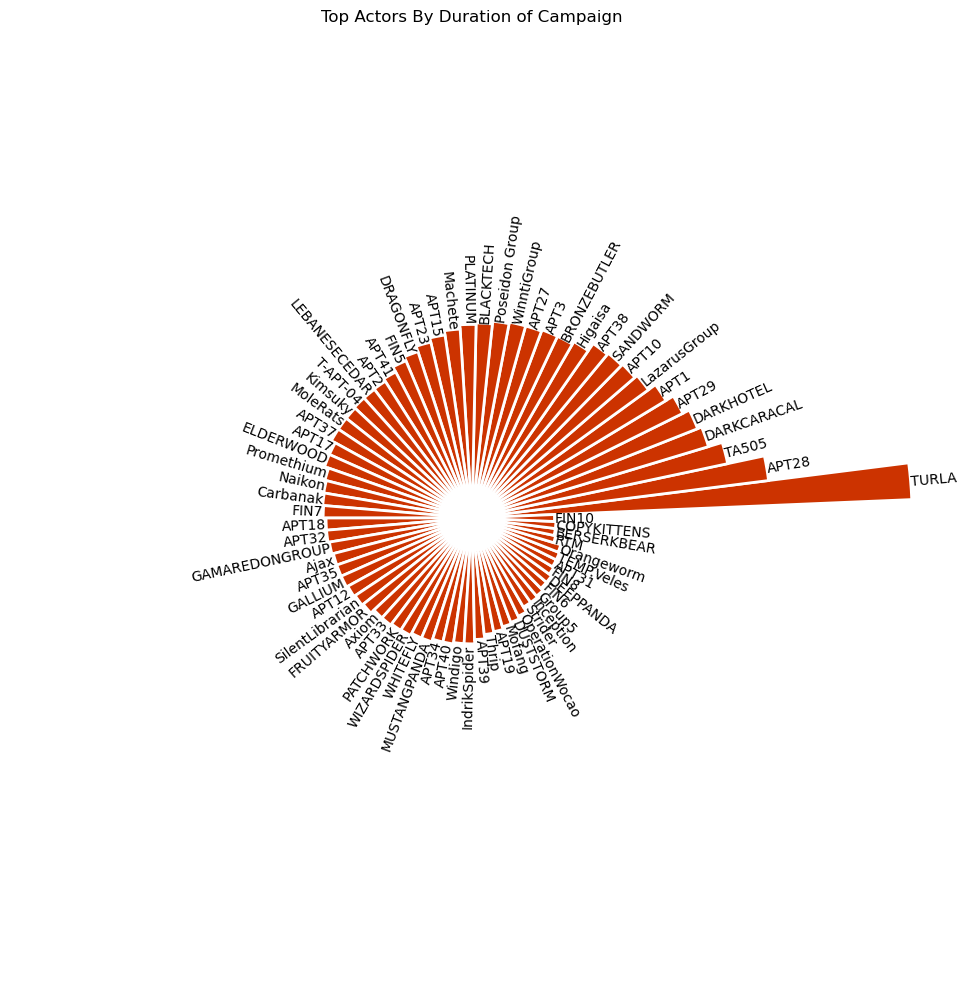

In [13]:
# initialize the figure
plt.figure(figsize=(12,12))
ax = plt.subplot(111, polar=True)
plt.title('Top Actors By Duration of Campaign')
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 100
lowerLimit = 50
labelPadding = 4

# Compute max and min in the dataset
max = dur_country['Campaign_Duration'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * dur_country.Campaign_Duration + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(dur_country.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(dur_country.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="#CC3300",
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, dur_country["Actor_Label"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 
    

# Let's Find the Most Recently Active Groups

In [14]:
groups_df['Days_Since_Active'] = calculate_last_active(groups_df['Last Seen']); 
print(groups_df['Days_Since_Active'].describe())
print("\nThe most recent group activity was", groups_df['Days_Since_Active'].min(), 'days ago.\nHowever, some group activity was as long as', round(groups_df['Days_Since_Active'].max()/365), 'years ago.')

count     121.000000
mean      838.157025
std       800.702421
min        22.000000
25%       162.000000
50%       650.000000
75%      1319.000000
max      4545.000000
Name: Days_Since_Active, dtype: float64

The most recent group activity was 22 days ago.
However, some group activity was as long as 12 years ago.


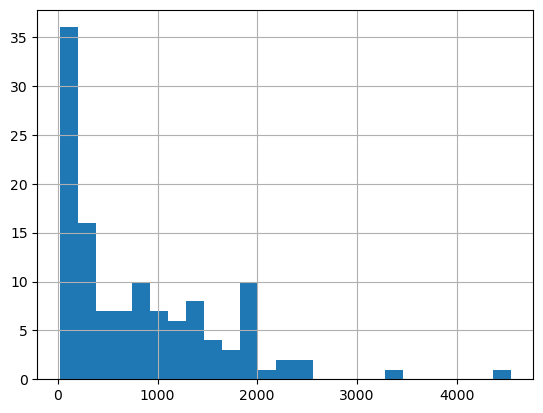

In [15]:
groups_df['Days_Since_Active'].hist(bins = 25);

# Examine the suspected group's motives

In [16]:
motives = pd.read_excel(path + 'MITRE_Actor_DATA2.xlsx',sheet_name='Actor_MOTIVES', header=0, index_col=None)
motives.columns = ['Actor_Label', 'Assessed Motive']
groups_df = groups_df.merge(motives, on='Actor_Label', how= 'left')

In [17]:
print('According to Thai CERT, most actors are motivated by information theft. Here are the suspected motives of the groups in the MITRE dataset:\n')
groups_df['Assessed Motive'].value_counts()

According to Thai CERT, most actors are motivated by information theft. Here are the suspected motives of the groups in the MITRE dataset:



Information theft and espionage      88
Military Advantage                   27
Financial gain                       24
Support cyber operations             16
Economic advantage                   11
Political gain                       10
Sabotage and Destruction              6
Law enforcement and/or oppression     5
Unknown                               3
Hacktivism                            1
Name: Assessed Motive, dtype: int64

In [18]:
motive_by_country = groups_df[['Assessed Motive', 'Group_Name', 'Country']]
motive_by_country
motive_by_country.drop_duplicates(inplace=True)
motive_by_country.drop('Group_Name', axis = 1, inplace=True)
motive_by_country_count =motive_by_country.groupby(['Country', 'Assessed Motive'])['Assessed Motive'].count()
motive_by_country_count = pd.DataFrame(motive_by_country_count)
motive_by_country_count.columns = ['Number of Groups']
motive_by_country_count.reset_index(inplace=True)
#motive_by_country_count.columns = ['Country', 'Assessed Motive', 'Number of Groups']
motive_by_country_count

<ipython-input-18-027f9fa6d7b9>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\cindy\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Country,Assessed Motive,Number of Groups
0,Brazil,Information theft and espionage,1
1,China,Economic advantage,9
2,China,Financial gain,2
3,China,Information theft and espionage,40
4,China,Law enforcement and/or oppression,1
5,China,Military Advantage,14
6,China,Political gain,3
7,China,Support cyber operations,7
8,Gaza,Hacktivism,1
9,Global,Financial gain,1


In [19]:
industry = pd.read_excel(path + 'MITRE_Actor_DATA2.xlsx',sheet_name='Actor_Industry', header=0, index_col=None)
industry.columns = ['Actor_Label', 'Industries Targeted']
industry['Industries Targeted'].value_counts()[:30]
groups_df = groups_df.merge(industry, on='Actor_Label', how= 'left')

In [20]:
groups_df.describe(include='all')

<ipython-input-20-bd78417689b8>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

<ipython-input-20-bd78417689b8>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

<ipython-input-20-bd78417689b8>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,Group_ID,Group_Name,description,created,Associated_Groups,Actor_Label,Country,Campaign Start,Last Seen,Affiliation,State-Sponsored,Organization,Campaign_Duration,Days_Since_Active,Assessed Motive,Industries Targeted
count,1666,1666,1666,1666,1666,1666,1666,1666,1666,1666,1666,1666,1666.000000,1666.000000,1660,1660
unique,121,121,121,42,64,121,21,24,58,8,4,17,NaN,NaN,10,63
top,G0016,APT29,[APT29](https://attack.mitre.org/groups/G0016)...,2017-05-31 00:00:00,nan,APT29,China,2013-01-01 00:00:00,2020-12-31 00:00:00,Government,Yes,Unknown,NaN,NaN,Information theft and espionage,Government
freq,98,98,98,813,376,98,723,321,188,764,1327,1244,NaN,NaN,637,140
first,NaN,NaN,NaN,2017-05-31 00:00:00,NaN,NaN,NaN,1996-01-01 00:00:00,2008-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2021-04-14 00:00:00,NaN,NaN,NaN,2021-01-01 00:00:00,2021-05-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3294.136255,536.022809,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1647.870909,600.837599,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.000000,22.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2372.000000,103.000000,NaN,NaN


There are 1092397 words in the group descriptions.


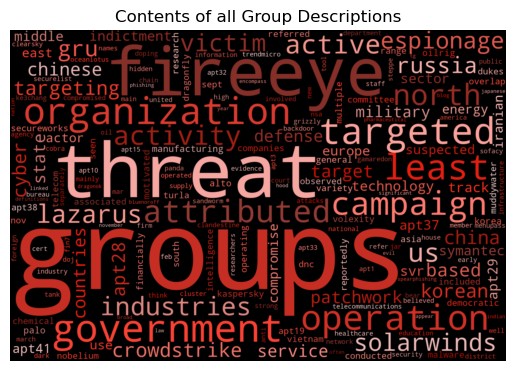

In [21]:
groups_df['description'] = groups_df['description'].astype('str')
text = " ".join(about for about in groups_df['description'])
#Remove all group IDs for clarity
pattern = r"[gG][\d]{4}"
text = re.sub(pattern, "", text)
text = text.lower().strip()

print ("There are {} words in the group descriptions.".format(len(text)))
stopwords = set(STOPWORDS)
stopwords.update(["primarily", "may", "will", "used", "group",'january', 'april', 'december','oct', 'u','s', 'uk', "report", "reporting", 'apr', 'aug', 'jan','jul', 'gov','september','june', 'including', 'eset', "written",'name', 'known','unit', 'dec', "citation", "https", "attack", "mitre", "org", "software"])

wordcloud = WordCloud(stopwords=stopwords, background_color="black", width=1800, height=1200, collocations=False).generate(text);
plt.imshow(wordcloud.recolor(color_func=random_redcolor_func, random_state=3),
           interpolation="bilinear")
plt.title('Contents of all Group Descriptions');
plt.axis('off')
plt.show()
cloud =  wordcloud.to_file('group_description.png')

In [22]:
gov_sponsored = groups_df[['Group_Name', 'State-Sponsored']]

In [23]:
gov_sponsored.drop_duplicates(inplace=True)
gov_sponsored_count =gov_sponsored['State-Sponsored'].value_counts()
gov_sponsored_count = pd.DataFrame(gov_sponsored_count)
gov_sponsored_count.reset_index(inplace=True)
gov_sponsored_count.columns = ['State-Sponsored', 'Number of Groups']
gov_sponsored_count

<ipython-input-23-961537ed0555>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,State-Sponsored,Number of Groups
0,Yes,57
1,Unknown,28
2,No,22
3,Probable,14


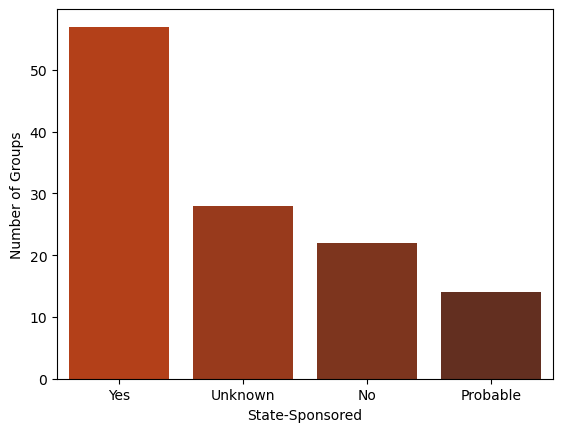

In [24]:
sns.barplot(x=gov_sponsored_count['State-Sponsored'],y=gov_sponsored_count['Number of Groups'],palette =sns.dark_palette('#CC3300', reverse=True));

In [25]:
group_country = groups_df[['Group_Name', 'Country']]
group_country.drop_duplicates(inplace=True)
group_country_count = pd.DataFrame(group_country['Country'].value_counts())
group_country_count.reset_index(inplace=True)
group_country_count.columns = ['Country', 'Number of Groups']
group_country_count['chart_text'] = group_country_count['Country'] + '-' + group_country_count['Number of Groups'].astype('str')
group_country_count

<ipython-input-25-d32e9891c6a0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Country,Number of Groups,chart_text
0,China,44,China-44
1,Russia,18,Russia-18
2,Unattributed,18,Unattributed-18
3,Iran,13,Iran-13
4,North Korea,5,North Korea-5
5,Middle East,3,Middle East-3
6,South Korea,2,South Korea-2
7,Lebanon,2,Lebanon-2
8,Turkey,2,Turkey-2
9,United States,2,United States-2


In [26]:
data = dict(
        type = 'choropleth',
        colorscale = 'Earth',
        reversescale = True,
        locations = group_country_count['Country'],
        locationmode = "country names",
        z = group_country_count['Number of Groups'],
        text = group_country_count['Country'],
        colorbar = {'title' : 'Number of Groups'},
      ) 

layout = dict(title = 'Number of Threat Actor Groups By Country',
                geo = dict(showframe = False,projection = {'type':'stereographic'})
             )

In [27]:
choromap = go.Figure(data = [data],layout = layout)
plot(choromap,validate=False)

'temp-plot.html'

In [28]:
group_stats = pd.DataFrame(groups_df.describe(include='all'))
group_stats.reset_index(inplace=True)
group_stats

<ipython-input-28-fb5782740c75>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

<ipython-input-28-fb5782740c75>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

<ipython-input-28-fb5782740c75>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,index,Group_ID,Group_Name,description,created,Associated_Groups,Actor_Label,Country,Campaign Start,Last Seen,Affiliation,State-Sponsored,Organization,Campaign_Duration,Days_Since_Active,Assessed Motive,Industries Targeted
0,count,1666,1666,1666,1666,1666,1666,1666,1666,1666,1666,1666,1666,1666.000000,1666.000000,1660,1660
1,unique,121,121,121,42,64,121,21,24,58,8,4,17,NaN,NaN,10,63
2,top,G0016,APT29,[APT29](https://attack.mitre.org/groups/G0016)...,2017-05-31 00:00:00,nan,APT29,China,2013-01-01 00:00:00,2020-12-31 00:00:00,Government,Yes,Unknown,NaN,NaN,Information theft and espionage,Government
3,freq,98,98,98,813,376,98,723,321,188,764,1327,1244,NaN,NaN,637,140
4,first,NaN,NaN,NaN,2017-05-31 00:00:00,NaN,NaN,NaN,1996-01-01 00:00:00,2008-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,last,NaN,NaN,NaN,2021-04-14 00:00:00,NaN,NaN,NaN,2021-01-01 00:00:00,2021-05-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3294.136255,536.022809,NaN,NaN
7,std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1647.870909,600.837599,NaN,NaN
8,min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.000000,22.000000,NaN,NaN
9,25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2372.000000,103.000000,NaN,NaN


# Export files for Tableau Use

In [30]:
group_stats.to_csv('mitre_group_stats.csv', header=True, index=False)
groups_df.to_csv('mitre_group_df.csv', header=True, index=False)